In [1]:
import os
import subprocess
import shutil
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import time
import pyspark
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
spark = SparkSession.builder.appName("Read Parquet File").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 10000)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/11 04:36:41 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/11 04:36:42 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/11 04:36:42 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/11 04:36:42 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
# check bucket to load file from
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/danilm/final_df_sample' | head -n 6

Found 4413 items
-rwx------   3 root root          0 2023-03-11 01:52 gs://msca-bdp-students-bucket/shared_data/danilm/final_df_sample/_SUCCESS
-rwx------   3 root root       5298 2023-03-11 01:45 gs://msca-bdp-students-bucket/shared_data/danilm/final_df_sample/part-00000-77928e78-5b6d-422d-8d0d-403d9bfdc6ed-c000.snappy.parquet
-rwx------   3 root root       5763 2023-03-11 01:45 gs://msca-bdp-students-bucket/shared_data/danilm/final_df_sample/part-00001-77928e78-5b6d-422d-8d0d-403d9bfdc6ed-c000.snappy.parquet
-rwx------   3 root root       5070 2023-03-11 01:45 gs://msca-bdp-students-bucket/shared_data/danilm/final_df_sample/part-00003-77928e78-5b6d-422d-8d0d-403d9bfdc6ed-c000.snappy.parquet
-rwx------   3 root root       5672 2023-03-11 01:45 gs://msca-bdp-students-bucket/shared_data/danilm/final_df_sample/part-00004-77928e78-5b6d-422d-8d0d-403d9bfdc6ed-c000.snappy.parquet


In [4]:
%%time
# read the parque sample_file 
sample_df = spark.read.format('parquet').load('gs://msca-bdp-students-bucket/shared_data/danilm/final_df_sample')

CPU times: user 8.61 ms, sys: 130 µs, total: 8.74 ms
Wall time: 7.4 s


In [8]:
# count of the dataframe
sample_df.count()

9567

In [5]:
# testing
sample_df.limit(10).toPandas()

,name,screen_name,verified,friends_count,followers_count,location,description,favourites_count,reply_count,retweet_count,created_at,tweet_text
0,Live Agile,agile_live,False,3745,3410,"Portsmouth, England",#Alcoholic #Anxious #Sober. After realising the deep effects of anxiety and addiction I’ve spent years identifying how to win and regain my life. #RecoveryPosse,11122,0.0,14.0,Mon Apr 20 11:41:49 +0000 2020,"@ExtinctionR I'm in Pakistan where 33 million people have been displaced....so yeah. I'm on not on edge. I've actively tipped over. Screaming about climate change for years only to watch in mute despair as half the country sinks. Bridges, roads, homes, schools gone."
1,.,thebongolese,False,980,8266,Africa,"Professional baby girl, Travel and Documentary Photographer and Auteur",15813,NaN,NaN,Thu Apr 12 15:44:57 +0000 2012,Randomly thinking of the Zimbabwe UFO Sighting in 1994. Aliens showed up in a school and told the kids about “climate change” ….
2,🇺🇲 Ultra MAGA Trump Girl,TrumpGi79056629,False,1146,691,None,"Conservative, America first, God fearing Patriot.\n 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇲",5972,201.0,1629.0,Mon Apr 25 21:43:27 +0000 2022,"BREAKING REPORT: Just as Joe Biden prepares to issue EXECUTIVE ORDERS ON CLIMATE CHANGE, NY Times / Siena College Poll reveals only ONE PERCENT of Americans and THREE PERCENT OF DEMOCRATS think climate is THE MOST IMPORTANT PROBLEM facing the Country..."
3,Lou Wall,LouWall48323834,False,189,268,None,I believe in the Charter of Rights and Freedoms for all Canadians. NO DM’s or I will block you.,14939,203.0,1647.0,Mon Jan 31 23:05:53 +0000 2022,"BREAKING REPORT: Just as Joe Biden prepares to issue EXECUTIVE ORDERS ON CLIMATE CHANGE, NY Times / Siena College Poll reveals only ONE PERCENT of Americans and THREE PERCENT OF DEMOCRATS think climate is THE MOST IMPORTANT PROBLEM facing the Country..."
4,Astrosfan,WilliamHartly,False,149,11,None,None,1084,0.0,1.0,Thu Jul 14 16:38:31 +0000 2022,Radical tree hugger @krismayes says Climate Change is her top priority. \n\nShe has devoted her life to ending fossil fuels - we have high gas prices because of radical professors like Mayes.
5,candyhorner1,tupelohoney2000,False,201,663,None,None,204960,2.0,15.0,Sat Jun 02 02:24:57 +0000 2012,Radical tree hugger @krismayes says Climate Change is her top priority. \n\nShe has devoted her life to ending fossil fuels - we have high gas prices because of radical professors like Mayes.
6,WestCoast,WestCoa2054,False,17,338,None,None,145,NaN,NaN,Wed Nov 02 00:39:41 +0000 2022,"Are the Clintons and Obamas or Oprah going to open their beach homes for these guys ? Miami should begin 'preparing for evacuation' due to climate change, Berkeley professor argues\n\nhttps://t.co/yltIn0KEHq"
7,Cakes,cakes_iam,False,7207,6977,"Las Vegas, NV",healthcare worker. Wife/mom/Moms Demand volunteer/ views & uterus are my own. she/ her #Resist #EndGunViolence #GetVaccinated,183416,449.0,2762.0,Tue May 26 00:04:07 +0000 2009,Refresher on what a “pro-life” agenda ACTUALLY looks like:\n\n- gun safety laws\n- taking action on climate change\n- protecting LGBT rights\n- healthcare for all\n- expanding pre-natal care\n- expanding mental healthcare \n- expanding childcare\n- universal preschool\n- free school meals
8,karen petersen #notakaren,karenApete90,False,100,35,None,"Mama, wife, teacher",39710,450.0,2770.0,Fri Feb 06 04:06:25 +0000 2015,Refresher on what a “pro-life” agenda ACTUALLY looks like:\n\n- gun safety laws\n- taking action on climate change\n- protecting LGBT rights\n- healthcare for all\n- expanding pre-natal care\n- expanding mental healthcare \n- expanding childcare\n- universal preschool\n- free school meals
9,Barbara Freethy,BarbaraFreethy,False,1188,406,None,"#1 NYT Bestselling Author of contemporary romance and romantic suspense. Tennis player, book lover, cat owner, mom, and sometimes watches too much reality TV",5511,451.0,2774.0,Fri Dec 04 04:24:47 +0000 2020,Refresher on what a “pro-life” agenda ACTUALLY looks like:\n\n- gun safet

In [6]:
# casting varriables to the appropriate data type
sample_df = sample_df.withColumn('reply_count', sample_df['reply_count'].cast(IntegerType()))
sample_df = sample_df.withColumn('retweet_count', sample_df['retweet_count'].cast(IntegerType()))
sample_df = sample_df.withColumn('friends_count', sample_df['friends_count'].cast(IntegerType()))
sample_df = sample_df.withColumn('retweet_count', sample_df['retweet_count'].cast(IntegerType()))
sample_df = sample_df.withColumn('favourites_count', sample_df['favourites_count'].cast(IntegerType()))

In [7]:
# validating the casts
sample_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- friends_count: integer (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- location: string (nullable = true)
 |-- description: string (nullable = true)
 |-- favourites_count: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- tweet_text: string (nullable = true)



# Analysis

### Top Twitterers

In [8]:
# create a new column with concatenated name, screen_name entries
sample_df =  sample_df.withColumn('name_username', concat(col('name'),lit(', '),col('screen_name')))
sample_df.limit(5).toPandas()

,name,screen_name,verified,friends_count,followers_count,location,description,favourites_count,reply_count,retweet_count,created_at,tweet_text,name_username
0,Live Agile,agile_live,False,3745,3410,"Portsmouth, England",#Alcoholic #Anxious #Sober. After realising the deep effects of anxiety and addiction I’ve spent years identifying how to win and regain my life. #RecoveryPosse,11122,0.0,14.0,Mon Apr 20 11:41:49 +0000 2020,"@ExtinctionR I'm in Pakistan where 33 million people have been displaced....so yeah. I'm on not on edge. I've actively tipped over. Screaming about climate change for years only to watch in mute despair as half the country sinks. Bridges, roads, homes, schools gone.","Live Agile, agile_live"
1,.,thebongolese,False,980,8266,Africa,"Professional baby girl, Travel and Documentary Photographer and Auteur",15813,NaN,NaN,Thu Apr 12 15:44:57 +0000 2012,Randomly thinking of the Zimbabwe UFO Sighting in 1994. Aliens showed up in a school and told the kids about “climate change” ….,"., thebongolese"
2,🇺🇲 Ultra MAGA Trump Girl,TrumpGi79056629,False,1146,691,None,"Conservative, America first, God fearing Patriot.\n 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇲",5972,201.0,1629.0,Mon Apr 25 21:43:27 +0000 2022,"BREAKING REPORT: Just as Joe Biden prepares to issue EXECUTIVE ORDERS ON CLIMATE CHANGE, NY Times / Siena College Poll reveals only ONE PERCENT of Americans and THREE PERCENT OF DEMOCRATS think climate is THE MOST IMPORTANT PROBLEM facing the Country...","🇺🇲 Ultra MAGA Trump Girl, TrumpGi79056629"
3,Lou Wall,LouWall48323834,False,189,268,None,I believe in the Charter of Rights and Freedoms for all Canadians. NO DM’s or I will block you.,14939,203.0,1647.0,Mon Jan 31 23:05:53 +0000 2022,"BREAKING REPORT: Just as Joe Biden prepares to issue EXECUTIVE ORDERS ON CLIMATE CHANGE, NY Times / Siena College Poll reveals only ONE PERCENT of Americans and THREE PERCENT OF DEMOCRATS think climate is THE MOST IMPORTANT PROBLEM facing the Country...","Lou Wall, LouWall48323834"
4,Astrosfan,WilliamHartly,False,149,11,None,None,1084,0.0,1.0,Thu Jul 14 16:38:31 +0000 2022,Radical tree hugger @krismayes says Climate Change is her top priority. \n\nShe has devoted her life to ending fossil fuels - we have high gas prices because of radical professors like Mayes.,"Astrosfan, WilliamHartly"


In [10]:
# Top 30 Highest Retweets
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_retweets = sample_df.groupby('name_username','description').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).limit(30).toPandas()

In [11]:
# Investigate profile descriptions to comprehend what is the background of the people who are at the top of the metric aggregation
top_30_retweets

,name_username,description,sum(retweet_count)
0,"mary margaret mucha, marymargaret70",None,20871
1,"heather, heathernataliee",🙂,20865
2,"VinceMeat, exponentbracket",Vince\n| hi i'm a four kinnie \n| he/they \n| creator of Diverse Articles | i draw cool things \n| 16\n| art tag: #vinceart\n@foursymoved ILYSM 💋,20849
3,"#BLM, acharya_dude",Tweets abt transportation and land use. Tweets are my own opinions.,20834
4,"SRPeel, SRPeel",Father of 2. Lifelong political junkie. Stroke survivor.,20819
5,"Marianne Collins ☮️, collinsmarianne","Love plants, tree and nature! Love to pray and believe ALL people are created equal.",20817
6,"Dr. Lynn Roseberry ☮️ 🌻🇺🇸🇩🇰🇪🇺, LynnRoseberry",Psychotherapist. Diversity and Inclusion Consultant. I tweet about #gender #diversity #humanrights #ruleoflaw US UK DK politics she/her,20771
7,"Linda Conner💉💉💉💉Democrat,🌊🌊🌊, Jazzlyn317","70 + Baby boomer ,Retired Nurse ,married ,grandmother and anti trump and❤ Bidden Harris!!grandmother to 2 Sailors Resister!http://BLM.No DMs!🌊🇺🇲",20762
8,"🌞zusiesunshine 🌻😻, zusiesunshine","Love kitties. Registered Independent, but have never & would never vote Red…ever. Never trump. #SaveOurDemocracy #AbolishTheElectoralCollege",20638
9,"nest DC, NestDC",NEST DC is Washington’s only boutique property management and design company that delights in every detail.,20631


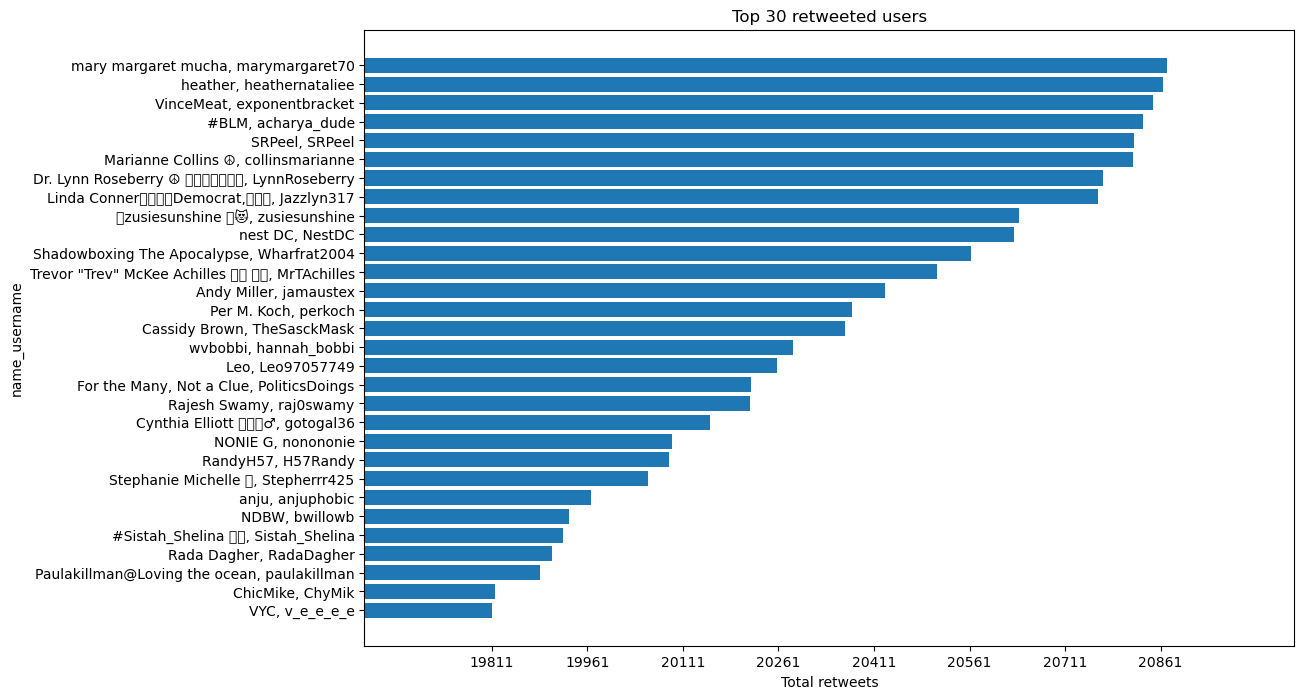

In [12]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_retweets['name_username'], width=top_30_retweets['sum(retweet_count)'])
plt.xlabel('Total retweets')
plt.xlim(top_30_retweets['sum(retweet_count)'].min()-200, top_30_retweets['sum(retweet_count)'].max()+200)
plt.xticks(range(top_30_retweets['sum(retweet_count)'].min(), top_30_retweets['sum(retweet_count)'].max(), 150))
plt.ylabel('name_username')
plt.title('Top 30 retweeted users')
plt.gca().invert_yaxis()
plt.show()

In [9]:
# Top 30 Highest Replies
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_replies = sample_df.groupby('name_username','description').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).limit(30).toPandas()

In [10]:
# Investigate profile descriptions to comprehend what is the background of the people who are at the top of the metric aggregation
top_30_replies

,name_username,description,sum(reply_count)
0,"mary margaret mucha, marymargaret70",None,2113
1,"heather, heathernataliee",🙂,2112
2,"VinceMeat, exponentbracket",Vince\n| hi i'm a four kinnie \n| he/they \n| creator of Diverse Articles | i draw cool things \n| 16\n| art tag: #vinceart\n@foursymoved ILYSM 💋,2106
3,"#BLM, acharya_dude",Tweets abt transportation and land use. Tweets are my own opinions.,2105
4,"Marianne Collins ☮️, collinsmarianne","Love plants, tree and nature! Love to pray and believe ALL people are created equal.",2105
5,"SRPeel, SRPeel",Father of 2. Lifelong political junkie. Stroke survivor.,2105
6,"Dr. Lynn Roseberry ☮️ 🌻🇺🇸🇩🇰🇪🇺, LynnRoseberry",Psychotherapist. Diversity and Inclusion Consultant. I tweet about #gender #diversity #humanrights #ruleoflaw US UK DK politics she/her,2103
7,"Linda Conner💉💉💉💉Democrat,🌊🌊🌊, Jazzlyn317","70 + Baby boomer ,Retired Nurse ,married ,grandmother and anti trump and❤ Bidden Harris!!grandmother to 2 Sailors Resister!http://BLM.No DMs!🌊🇺🇲",2103
8,"🌞zusiesunshine 🌻😻, zusiesunshine","Love kitties. Registered Independent, but have never & would never vote Red…ever. Never trump. #SaveOurDemocracy #AbolishTheElectoralCollege",2070
9,"nest DC, NestDC",NEST DC is Washington’s only boutique property management and design company that delights in every detail.,2065


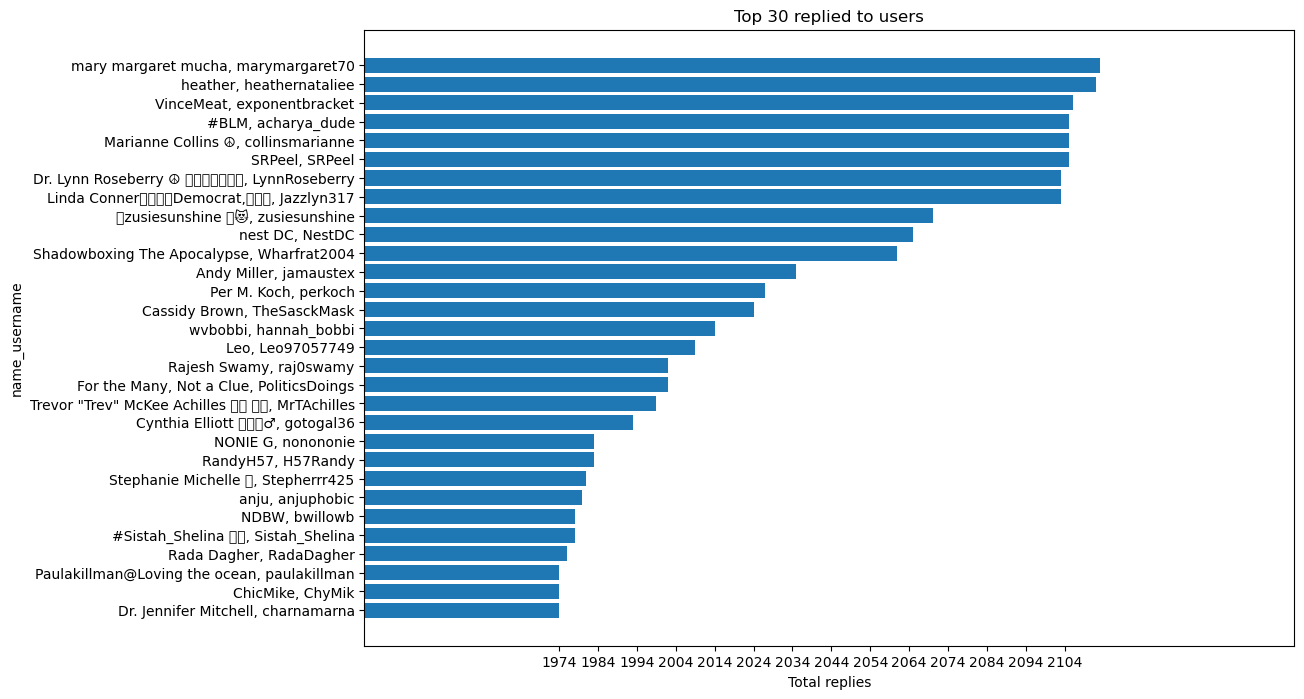

In [11]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_replies['name_username'], width=top_30_replies['sum(reply_count)'])
plt.xlabel('Total replies')
plt.xlim(top_30_replies['sum(reply_count)'].min()-50, top_30_replies['sum(reply_count)'].max()+50)
plt.xticks(range(top_30_replies['sum(reply_count)'].min(), top_30_replies['sum(reply_count)'].max(), 10))
plt.ylabel('name_username')
plt.title('Top 30 replied to users')
plt.gca().invert_yaxis()
plt.show()

In [9]:
# Top 30 most followed twitterers
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_followers = sample_df.groupby('name_username','description').agg(sum('followers_count')).orderBy('sum(followers_count)',ascending=False).limit(30).toPandas()

In [10]:
top_30_followers

,name_username,description,sum(followers_count)
0,"NDTV, ndtv",Breaking news alerts from India.\n\nInstagram: http://instagram.com/ndtv\nYouTube: http://youtube.com/ndtv,17066504
1,"Hindustan Times, htTweets",One of India's largest media companies. Latest news from around the world. Retweets are not endorsements,8692930
2,"Mark Ruffalo, MarkRuffalo","A husband, father, actor, director, & a climate justice advocate with an eye out for a better, brighter, cleaner, & more hopeful future for all of us.",8378012
3,"Gizmodo, Gizmodo",We come from the future,2785899
4,"Education Week, educationweek","Inspiring you through K-12 news, analysis, and opinion. Empowering you to make a difference in your community.\n\nSign up for our newsletter: https://t.co/rFHMPLoZtc",2761422
5,"NowThis, nowthisnews",Stories that move. Subscribe to our daily newsletter: http://go.nowth.is/knowthis,2744481
6,"NowThis, nowthisnews",Stories that move. Subscribe to our daily newsletter: http://go.nowth.is/knowthis_twitt…,2743303
7,"Forbes India, ForbesIndia","Bringing you the best conversations on Indian and international business, in alliance with @Forbes. Run by our journalists. Read more at http://forbesindia.com",1282802
8,"The New Vision, newvisionwire","Breaking News, Current Events and News Analysis from Uganda's Leading Daily. #VisionUpdates\n\n#EPaper - http://epapers.visiongroup.co.ug",1224977
9,"The National, TheNationalNews","The world has borders. Our stories don't.\n• Global, MENA and UAE news\n• Middle East explained\n• Business \n• Sport\n• Arts and lifestyle\n• Opinion",1109355


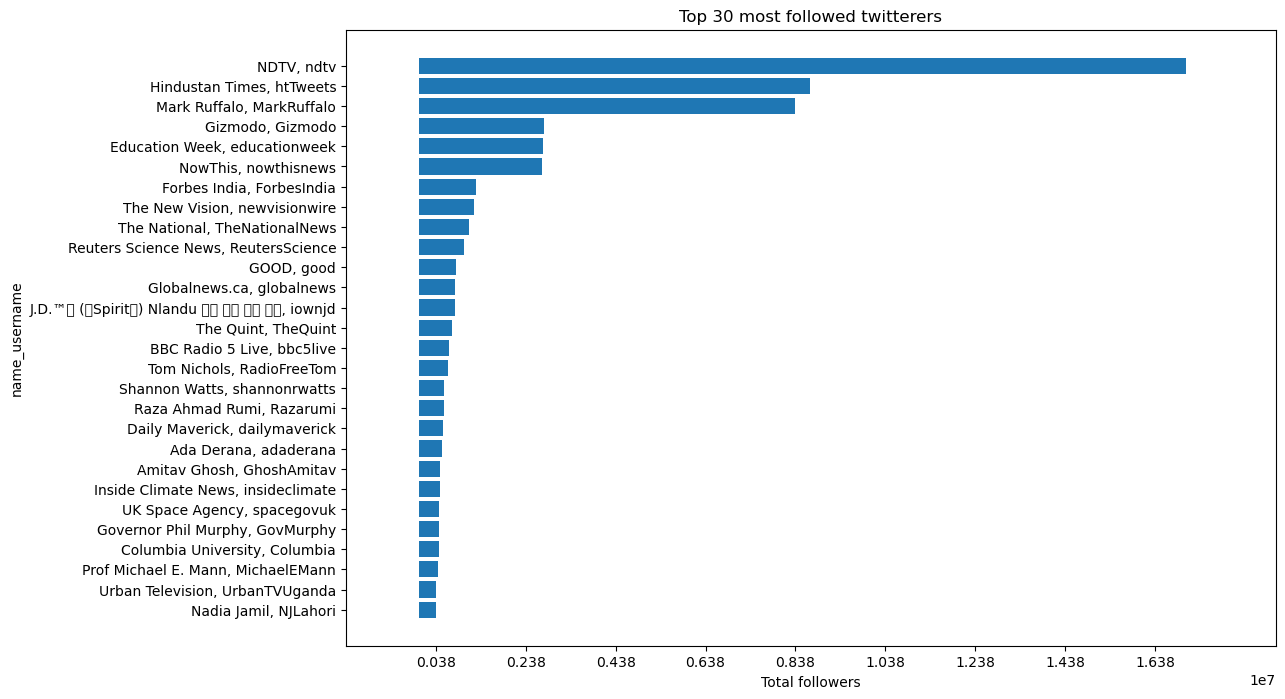

In [31]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_followers['name_username'], width=top_30_followers['sum(followers_count)'])
plt.xlabel('Total followers(millions)')
plt.xlim(top_30_followers['sum(followers_count)'].min()-2000000, top_30_followers['sum(followers_count)'].max()+2000000)
plt.xticks(range(top_30_followers['sum(followers_count)'].min(), top_30_followers['sum(followers_count)'].max(), 2000000))
plt.ylabel('name_username')
plt.title('Top 30 most followed twitterers')
plt.gca().invert_yaxis()
plt.show()

In [32]:
# Top 30 most befriended twitterers
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_friends = sample_df.groupby('name_username','description').agg(sum('friends_count')).orderBy('sum(friends_count)',ascending=False).limit(30).toPandas()

In [33]:
# Investigate profile descriptions to comprehend what is the background of the people who are at the top of the metric aggregation
top_30_friends

,name_username,description,sum(friends_count)
0,"J.D.™🦄 (🐯Spirit🐢) Nlandu 🇨🇩 🇧🇪 🇫🇷 🇺🇸, iownjd","A✍️@nerdinajock🚀CEO👨🏾‍💼@Twitter (@iOwnDigital™️)—🧢Mogul—Speaker and perpetual optimist, learn—Be cute, but real in this ugly world ✨Ask🗺J.D.🦚@letterstoJD",436449
1,"AppSame, AppSame",AppSame is about to stand up to the News bully and fight for America,186547
2,"Saleemul Huq, SaleemulHuq","Director, @ICCCAD and Senior Associate @IIED. Work on adaptation to climate change. Views presented are my own.",157623
3,"Furniture Assembly Experts - DC MD VA Baltimore, DC__MOVERS",Residential & Commercial furniture assembly - moving - Installation - junk furniture removal - in Washington DC - Maryland - Virginia - CALL 240-714-3649,151432
4,"TzConnect, tzDiscovery",Get live Tweets of current issues and share with friends,133627
5,"박성율- #ClimateEmergency, ppptec",#ActOnClimate.\n사람답게 살기/느리게 살기/소금으로 살기/\n토지난민연대/ 원주녹색연합/\nClimate- and environmental activist\n#ClimateEmergency,88217
6,"Mesa🇧🇦🇺🇦🇺🇸, ElectBlue2022",#DemVoice1 (FOUNDER) Democrats Activist Group 💙Being a Democrat is a lifestyle 💙To learn more about #DemVoice1 send me DM 🇺🇸🇧🇦,82262
7,"#VotingRightsAct, JesusNarrowWay",@staceyabrams @CheriBeasleyNC @ValDemings @DemocraticAgs @DemsofState @Dlcc @JonesforAR @senatedems @DemMayors @MichelleVForTx @demgovs @AaronDFordNV,76082
8,"David Benjamin, thetoyman1","Media Consultant, Lakers Fan, Vegas Expert/Dodger Fan/Radio/TV Producer/ News Junky/ Creator of Products/Proud Military Supporter/support Israel/",70904
9,"🇺🇸 Truth over Lies 🇺🇸, monnj6",🇺🇸 🇺🇸 Free speech advocate. Part time MAGA Patriot Booster. Anti MSM propaganda. 🇺🇸 🇺🇸,64121


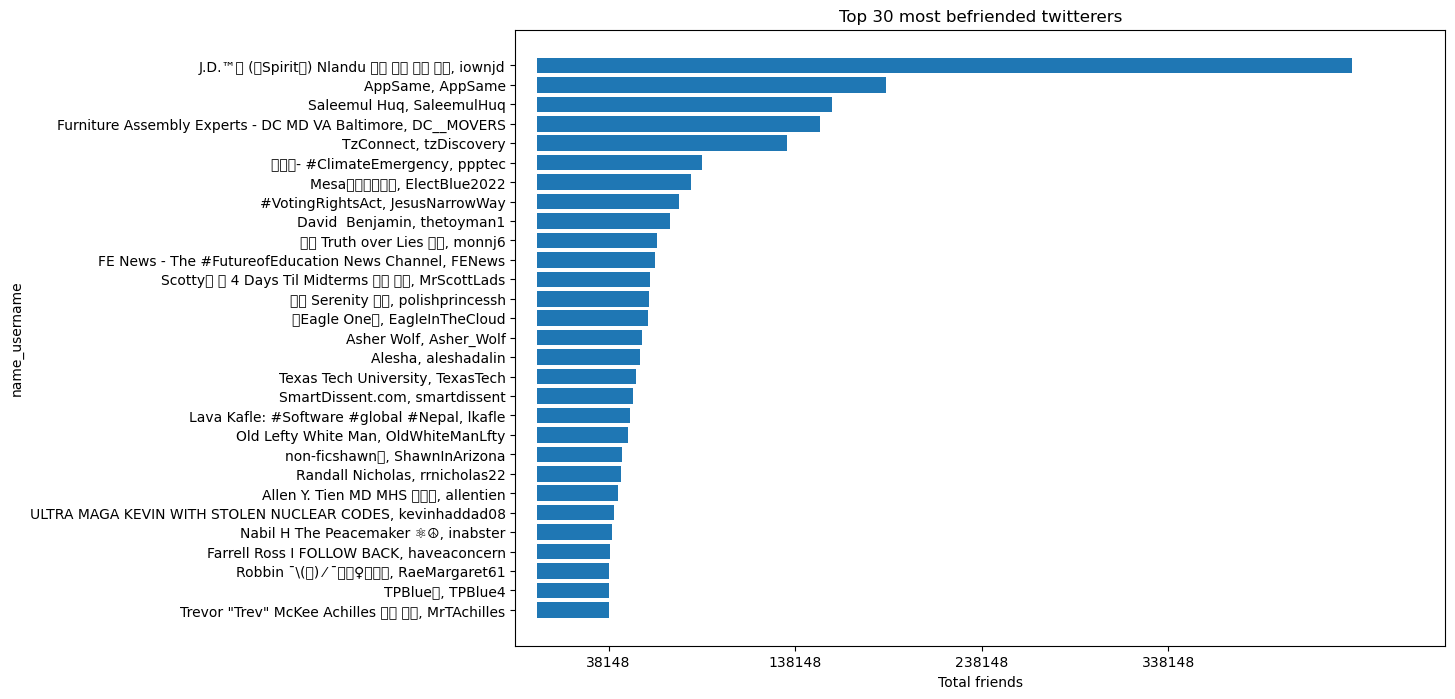

In [40]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_friends['name_username'], width=top_30_friends['sum(friends_count)'])
plt.xlabel('Total friends')
plt.xlim(top_30_friends['sum(friends_count)'].min()-50000, top_30_friends['sum(friends_count)'].max()+50000)
plt.xticks(range(top_30_friends['sum(friends_count)'].min(), top_30_friends['sum(friends_count)'].max(), 100000))
plt.ylabel('name_username')
plt.title('Top 30 most befriended twitterers')
plt.gca().invert_yaxis()
plt.show()

### Verified Accounts

In [42]:
# Investigate how many verified accounts are there in the dataset 
verified_or_not = sample_df.groupby('verified').agg(count(col('verified'))).toPandas()

In [48]:
verified_or_not

,verified,count(verified)
0,True,285
1,False,9282


In [50]:
verified_or_not['count(verified)'].sum()

9567

In [58]:
# adding a percentage column
verified_or_not['percent_of_total'] = (verified_or_not['count(verified)']/verified_or_not['count(verified)'].sum())*100
verified_or_not

,verified,count(verified),percent of total,percent_of_total
0,True,285,2.97899,2.97899
1,False,9282,97.02101,97.02101


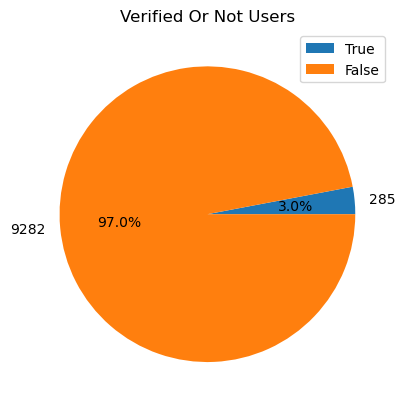

In [74]:
# Pie Chart with percentages
plt.pie(verified_or_not['count(verified)'], labels=verified_or_not['count(verified)'], autopct='%1.1f%%')
plt.legend(verified_or_not['verified'])
plt.title('Verified Or Not Users')
plt.show()

### Top twitting locations

In [91]:
# Aggregating location based on reply count
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_loc_reply = sample_df.groupby('location').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).limit(29).toPandas()

In [92]:
top_30_loc_reply

,location,sum(reply_count)
0,None,494115
1,United States,22494
2,"California, USA",16651
3,USA,12291
4,California,11241
5,"Los Angeles, CA",10014
6,"Florida, USA",8708
7,"Washington, DC",7118
8,"Portland, OR",6034
9,CA,5845


In [146]:
# Creating another location group column with states to aggregate the data 
top_30_loc_reply['loc_grp'] = np.where(top_30_loc_reply['location'].str.contains(r'San F|Cali|CA'), 'CA', 
                                       np.where((top_30_loc_reply['location']=='USA')|(top_30_loc_reply['location']=='United States'),'USA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'DC'), 'DC',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Flor|FL'),'FL',
                                       np.where(top_30_loc_reply['location'].str.contains(r'New Y|NY'), 'NY',
                                       np.where(top_30_loc_reply['location'].str.contains(r'OR'), 'OR',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Mich'), 'MI',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Massa|MA'), 'MA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Tex|TX'), 'TX',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Ohio'), 'OH',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Pen|PA'), 'PA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Seat'), 'WA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'NV'), 'NV','')))))))))))))

# Removing the None entry to get a clearer percent frequency distribution across values
top_30_loc_reply = top_30_loc_reply.drop(index=0).reset_index(drop=True)

In [147]:
top_30_loc_reply

,location,sum(reply_count),loc_grp
0,"California, USA",16651,CA
1,USA,12291,USA
2,California,11241,CA
3,"Los Angeles, CA",10014,CA
4,"Florida, USA",8708,FL
5,"Washington, DC",7118,DC
6,"Portland, OR",6034,OR
7,CA,5845,CA
8,"Brooklyn, NY",5790,NY
9,"New York, USA",5594,NY


In [156]:
print('Unique Locations =',len(top_30_loc_reply['loc_grp'].unique()))

Unique Locations = 13


In [155]:
# Group By by the grouped locations, top 12 unique locations
top_loc_reply = top_30_loc_reply.groupby('loc_grp')['sum(reply_count)'].sum()

In [157]:
# Extracting the numbers
pies = []
for i in top_loc_reply:
    pies.append(i)
print(len(pies))

13


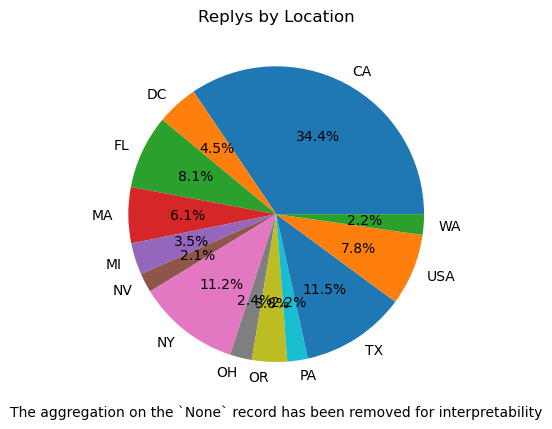

In [158]:
# Pie Chart
plt.pie(pies, labels=top_loc_reply.index.values, autopct='%1.1f%%')
plt.xlabel('The aggregation on the `None` record has been removed for interpretability')
plt.title('Replys by Location')
plt.show()

In [89]:
# Aggregating Locations based on retweet count
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_loc_retwt = sample_df.groupby('location').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).limit(27).toPandas()

In [93]:
top_30_loc_retwt

,location,sum(retweet_count)
0,None,3774519
1,United States,200713
2,"California, USA",133672
3,USA,107405
4,"Los Angeles, CA",85245
5,California,82743
6,"Washington, DC",65139
7,"Florida, USA",65115
8,"New York, USA",56252
9,"Portland, OR",53385


In [102]:
# Creating another location group column with states to aggregate the data 
top_30_loc_retwt['loc_grp'] = np.where(top_30_loc_retwt['location'].str.contains(r'San F|Cali|CA'), 'CA', 
                                       np.where((top_30_loc_retwt['location']=='USA')|(top_30_loc_retwt['location']=='United States'),'USA',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'DC'), 'DC',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Flor|FL'),'FL',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'New Y|NY'), 'NY',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'OR'), 'OR',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Mich'), 'MI',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Massa|MA'), 'MA',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Tex|TX'), 'TX',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Ohio'), 'OH',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Pen|PA'), 'PA',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Seat'), 'WA',''))))))))))))

# Removing the None entry to get a clearer percent frequency distribution across values
top_30_loc_retwt = top_30_loc_retwt.drop(index=0).reset_index(drop=True)

In [107]:
print('Unique Locations =',len(top_30_loc_retwt['loc_grp'].unique()))

Unique Locations = 12


In [129]:
# Group By by the grouped locations, top 12 unique locations
top_loc_retwt = top_30_loc_retwt.groupby('loc_grp')['sum(retweet_count)'].sum()

In [135]:
top_loc_retwt

loc_grp
CA     416443
DC      65139
FL     104432
MA      86704
MI      51963
NY     123961
OH      36579
OR      53385
PA      58107
TX     142397
USA    308118
WA      28681
Name: sum(retweet_count), dtype: int64

In [133]:
# Extracting the numbers
pies = []
for i in top_loc_retwt:
    pies.append(i)

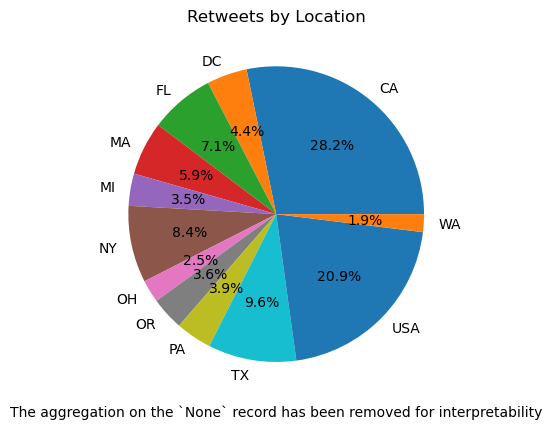

In [141]:
# Pie Chart
plt.pie(pies, labels=top_loc_retwt.index.values, autopct='%1.1f%%')
plt.xlabel('The aggregation on the `None` record has been removed for interpretability')
plt.title('Retweets by Location')
plt.show()

### Top twitting timelines

In [166]:
# create new month and year columns for timelines analysis 
sample_df =  sample_df.withColumn('month',split(col('created_at'),' ')[1])
sample_df =  sample_df.withColumn('year',split(col('created_at'),' ')[5])
sample_df.limit(5).toPandas()

,name,screen_name,verified,friends_count,followers_count,location,description,favourites_count,reply_count,retweet_count,created_at,tweet_text,name_username,month,year
0,Live Agile,agile_live,False,3745,3410,"Portsmouth, England",#Alcoholic #Anxious #Sober. After realising the deep effects of anxiety and addiction I’ve spent years identifying how to win and regain my life. #RecoveryPosse,11122,0.0,14.0,Mon Apr 20 11:41:49 +0000 2020,"@ExtinctionR I'm in Pakistan where 33 million people have been displaced....so yeah. I'm on not on edge. I've actively tipped over. Screaming about climate change for years only to watch in mute despair as half the country sinks. Bridges, roads, homes, schools gone.","Live Agile, agile_live",Apr,2020
1,.,thebongolese,False,980,8266,Africa,"Professional baby girl, Travel and Documentary Photographer and Auteur",15813,NaN,NaN,Thu Apr 12 15:44:57 +0000 2012,Randomly thinking of the Zimbabwe UFO Sighting in 1994. Aliens showed up in a school and told the kids about “climate change” ….,"., thebongolese",Apr,2012
2,🇺🇲 Ultra MAGA Trump Girl,TrumpGi79056629,False,1146,691,None,"Conservative, America first, God fearing Patriot.\n 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇲",5972,201.0,1629.0,Mon Apr 25 21:43:27 +0000 2022,"BREAKING REPORT: Just as Joe Biden prepares to issue EXECUTIVE ORDERS ON CLIMATE CHANGE, NY Times / Siena College Poll reveals only ONE PERCENT of Americans and THREE PERCENT OF DEMOCRATS think climate is THE MOST IMPORTANT PROBLEM facing the Country...","🇺🇲 Ultra MAGA Trump Girl, TrumpGi79056629",Apr,2022
3,Lou Wall,LouWall48323834,False,189,268,None,I believe in the Charter of Rights and Freedoms for all Canadians. NO DM’s or I will block you.,14939,203.0,1647.0,Mon Jan 31 23:05:53 +0000 2022,"BREAKING REPORT: Just as Joe Biden prepares to issue EXECUTIVE ORDERS ON CLIMATE CHANGE, NY Times / Siena College Poll reveals only ONE PERCENT of Americans and THREE PERCENT OF DEMOCRATS think climate is THE MOST IMPORTANT PROBLEM facing the Country...","Lou Wall, LouWall48323834",Jan,2022
4,Astrosfan,WilliamHartly,False,149,11,None,None,1084,0.0,1.0,Thu Jul 14 16:38:31 +0000 2022,Radical tree hugger @krismayes says Climate Change is her top priority. \n\nShe has devoted her life to ending fossil fuels - we have high gas prices because of radical professors like Mayes.,"Astrosfan, WilliamHartly",Jul,2022


In [167]:
# Monthly Total Sum of Retweets
month_retwt_sum = sample_df.groupby('month').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).toPandas()

In [168]:
month_retwt_sum

,month,sum(retweet_count)
0,Apr,1122001
1,Jun,1021815
2,Mar,914382
3,Feb,872083
4,May,868891
5,Jan,864157
6,Jul,859032
7,Oct,771627
8,Sep,770323
9,Aug,725768


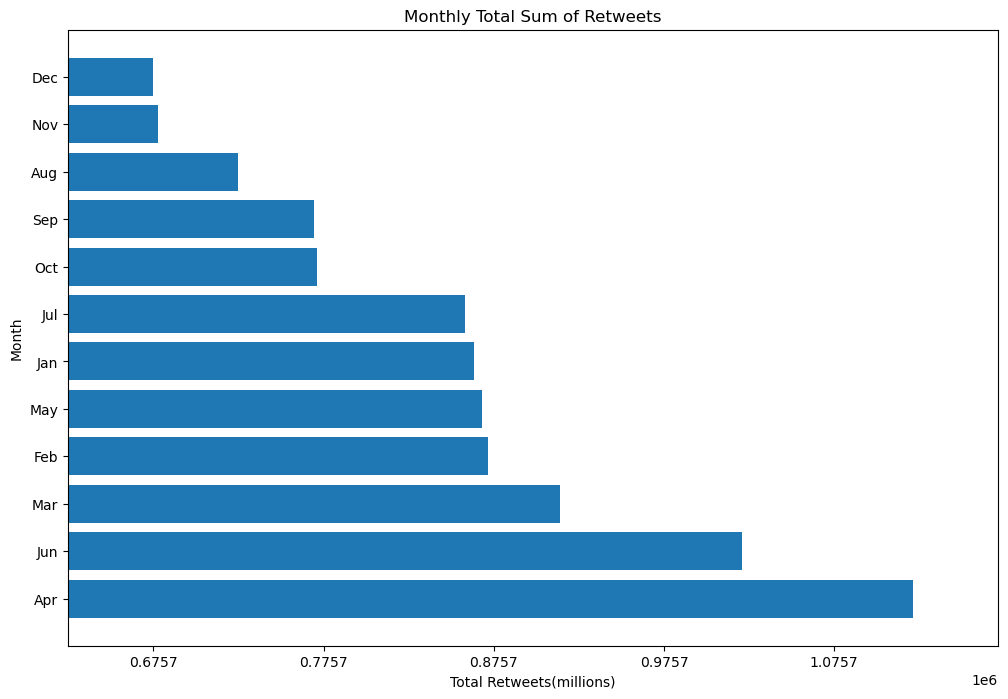

In [172]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=month_retwt_sum['month'], width=month_retwt_sum['sum(retweet_count)'])
plt.xlabel('Total Retweets(millions)')
plt.xlim(month_retwt_sum['sum(retweet_count)'].min()-50000, month_retwt_sum['sum(retweet_count)'].max()+50000)
plt.xticks(range(month_retwt_sum['sum(retweet_count)'].min(), month_retwt_sum['sum(retweet_count)'].max(), 100000))
plt.ylabel('Month')
plt.title('Monthly Total Sum of Retweets')
plt.show()

In [169]:
# Monthly Total Sum of Replies
month_reply_sum = sample_df.groupby('month').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).toPandas()

In [170]:
month_reply_sum

,month,sum(reply_count)
0,Apr,138267
1,Jun,126376
2,Mar,113409
3,Feb,112184
4,May,110759
5,Jan,109762
6,Jul,109168
7,Sep,99232
8,Aug,96989
9,Oct,96331


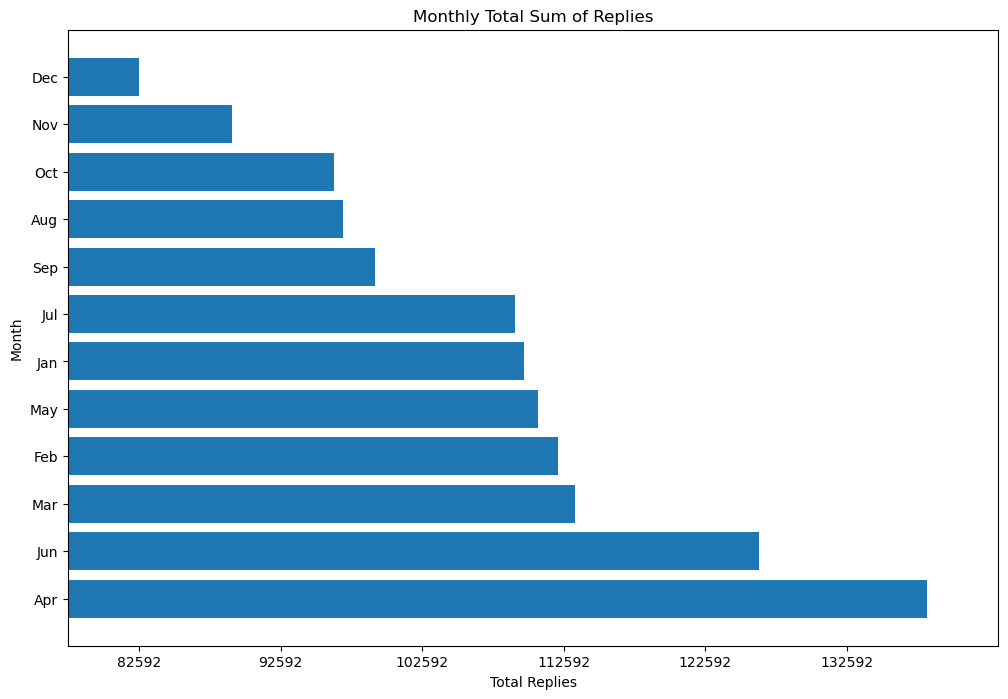

In [176]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=month_reply_sum['month'], width=month_reply_sum['sum(reply_count)'])
plt.xlabel('Total Replies')
plt.xlim(month_reply_sum['sum(reply_count)'].min()-5000, month_reply_sum['sum(reply_count)'].max()+5000)
plt.xticks(range(month_reply_sum['sum(reply_count)'].min(), month_reply_sum['sum(reply_count)'].max(), 10000))
plt.ylabel('Month')
plt.title('Monthly Total Sum of Replies')
plt.show()

In [177]:
# Yearly Total Sum of Retweets
year_retwt_sum = sample_df.groupby('year').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).toPandas()

In [178]:
year_retwt_sum

,year,sum(retweet_count)
0,2009,1370146
1,2020,850170
2,2012,822243
3,2011,808476
4,2017,759052
5,2022,719014
6,2014,661805
7,2016,626412
8,2021,618402
9,2013,611156


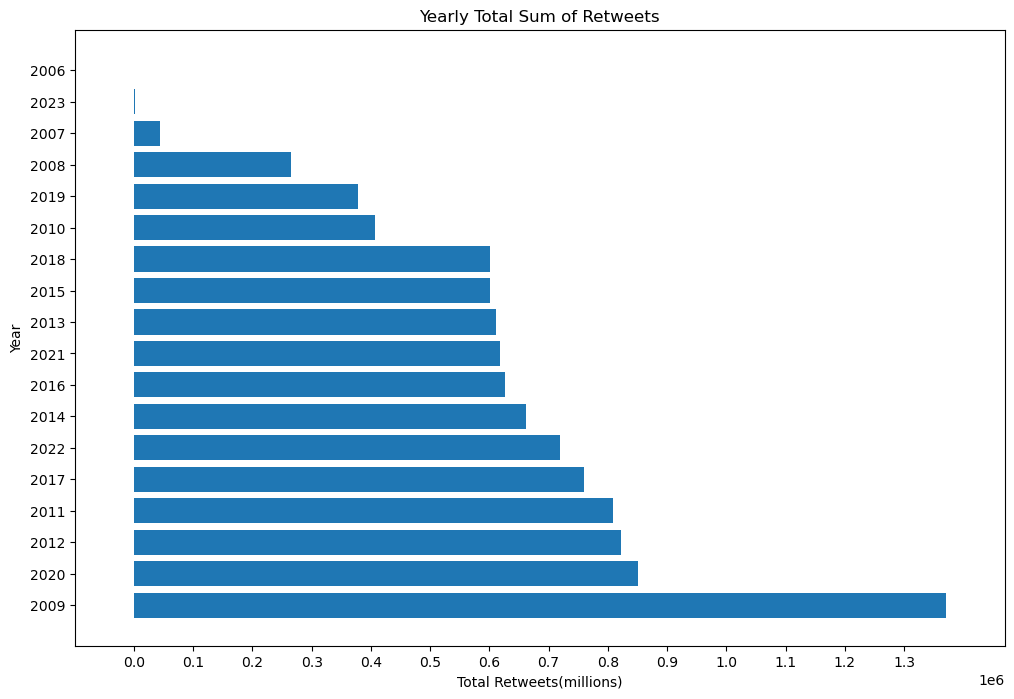

In [193]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=year_retwt_sum['year'], width=year_retwt_sum['sum(retweet_count)'])
plt.xlabel('Total Retweets(millions)')
plt.xlim(year_retwt_sum['sum(retweet_count)'].min()-100000, year_retwt_sum['sum(retweet_count)'].max()+100000)
plt.xticks(range(year_retwt_sum['sum(retweet_count)'].min(), year_retwt_sum['sum(retweet_count)'].max(), 100000))
plt.ylabel('Year')
plt.title('Yearly Total Sum of Retweets')
plt.show()

In [183]:
# Yearly Total Sum of Replies
year_reply_sum = sample_df.groupby('year').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).toPandas()

In [184]:
year_reply_sum

,year,sum(reply_count)
0,2009,165682
1,2020,103968
2,2022,102219
3,2011,101453
4,2012,100400
5,2017,92642
6,2021,84011
7,2014,82393
8,2016,79301
9,2013,78239


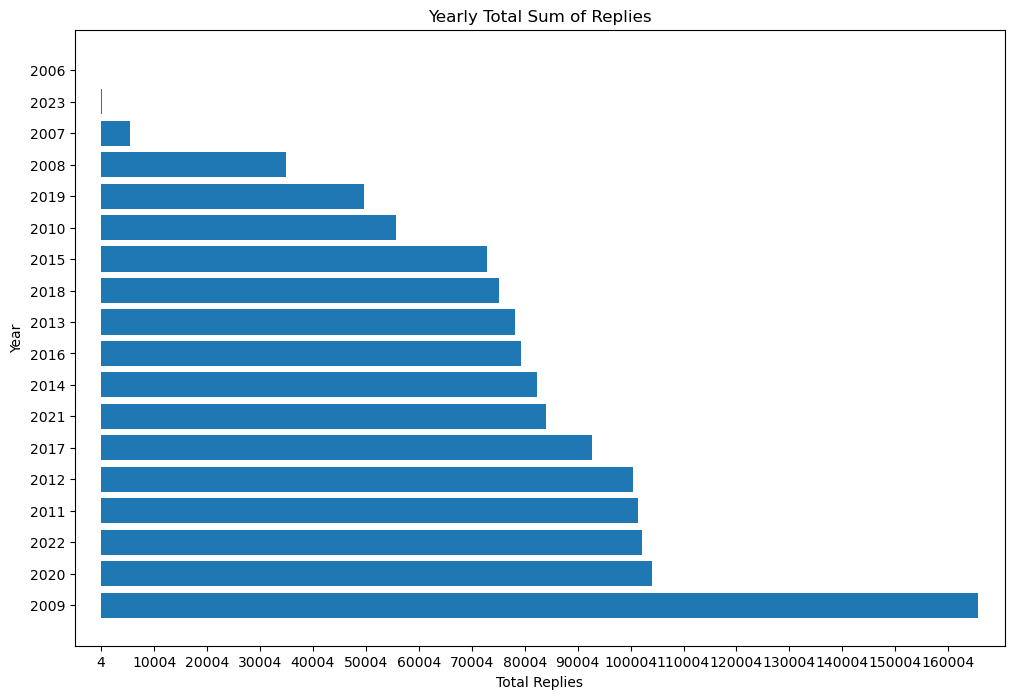

In [195]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=year_reply_sum['year'], width=year_reply_sum['sum(reply_count)'])
plt.xlabel('Total Replies')
plt.xlim(year_reply_sum['sum(reply_count)'].min()-5000, year_reply_sum['sum(reply_count)'].max()+5000)
plt.xticks(range(year_reply_sum['sum(reply_count)'].min(), year_reply_sum['sum(reply_count)'].max(), 10000))
plt.ylabel('Year')
plt.title('Yearly Total Sum of Replies')
plt.show()